Using the Kaggle dataset, same sample size as carnivores, more balance distribution

In [2]:
# Import libraries

import numpy as np
import pandas as pd

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import tensorflow as tf
import numpy as np
from keras import layers

import string
import re

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#!pip install -U libsvm-official

In [3]:
import os 
os.getcwd()

'/Users/rubyc/Desktop/NLP'

In [4]:
# read in test dataset 
test_df = pd.read_csv("~/Desktop/NLP/data/sentiment analysis dataset/test.csv", encoding='utf-8') 
# one-hot encode class column
test_df['sentiment'] = test_df['sentiment'].map({'positive' : 1, 'negative' : 0})
test_df = test_df[pd.notna(test_df['sentiment'])]

# read in train dataset
train_df = pd.read_csv("~/Desktop/NLP/data/sentiment analysis dataset/train.csv", encoding='utf-8') 
train_df['sentiment'] = train_df['sentiment'].map({'positive' : 1, 'negative' : 0})
train_df = train_df[pd.notna(train_df['sentiment'])]

# Concatenate 
input_df = pd.concat([test_df, train_df], ignore_index = True)
print("# of obs in train_df:", len(input_df))
print('Class distribution in train_df', input_df['sentiment'].value_counts())

# Convert text column to string
input_df['text'] = input_df['text'].astype(str)
input_df = input_df[pd.notna(input_df['sentiment'])]

# of obs in train_df: 18467
Class distribution in train_df sentiment
1.0    9685
0.0    8782
Name: count, dtype: int64


Class distribution on Carnivores dataset
Training class counts: Counter({1: 90, 0: 35})
Training class distribution: {1: 0.72, 0: 0.28}
Validation class counts: Counter({1: 15, 0: 10})
Validation class distribution: {0: 0.4, 1: 0.6}
Test class counts: Counter({0: 4, 1: 3})
Test class distribution: {0: 0.5714285714285714, 1: 0.42857142857142855}

## Creating subsets with same class distribution as carnivores dataset

In [7]:
# Splitting the training and test dataset by class
pos = input_df[input_df['sentiment'] == 1]
neg = input_df[input_df['sentiment'] == 0]

In [8]:
# create new datasets training, validation, and test set with the same number of observations and the same class distribution

def new_df(positive, negative, num_observation1, num_observation2, random_state):
    
    # subset dataframe 
    new_df1 = positive.sample(n = num_observation1, random_state = random_state)
    new_df2 = negative.sample(n = num_observation2, random_state = random_state)
    
    # Concatenate and shuffle
    new_dataframe = pd.concat([new_df1, new_df2], ignore_index = True).sample(frac = 1, random_state = random_state)
    
    return new_dataframe

# training set
train = new_df(pos, neg, 62, 62, 1337)

# check class distribution
print("training class distribution:", train['sentiment'].value_counts())

# Remove the sampled observations from the original datasets
train_subset_pos = train[train['sentiment'] == 1]
train_subset_neg = train[train['sentiment'] == 0]

remaining_pos = pos[~pos.isin(train_subset_pos)].dropna()
remaining_neg = neg[~neg.isin(train_subset_neg)].dropna()

# validation
validation = new_df(remaining_pos, remaining_neg, 12, 13, 1337)
# check class distribution
print("validation class distribution:", validation['sentiment'].value_counts())

validation_subset_pos = validation[validation['sentiment'] == 1]
validation_subset_neg = validation[validation['sentiment'] == 0]

remaining_pos = remaining_pos[~remaining_pos.isin(validation_subset_pos)].dropna()
remaining_neg = remaining_neg[~remaining_neg.isin(validation_subset_neg)].dropna()

# create new training dataset
test = new_df(remaining_pos, remaining_neg, 3, 4, 1337)

# check class distribution
print(test['sentiment'].value_counts())

training class distribution: sentiment
0.0    62
1.0    62
Name: count, dtype: int64
validation class distribution: sentiment
0.0    13
1.0    12
Name: count, dtype: int64
sentiment
0.0    4
1.0    3
Name: count, dtype: int64


In [9]:
# Convert 'text' to string
train['text'] = train['text'].astype(str)
validation['text'] = validation['text'].astype(str)
test['text'] = test['text'].astype(str)

# Convert 'sentiment' to integer
train['sentiment'] = train['sentiment'].astype(int)
validation['sentiment'] = validation['sentiment'].astype(int)
test['sentiment'] = test['sentiment'].astype(int)

In [10]:
# Shuffle 
train = train.sample(frac=1, random_state=1337).reset_index(drop=True)
validation = validation.sample(frac=1, random_state=1337).reset_index(drop=True)
test = test.sample(frac=1, random_state=1337).reset_index(drop=True)


# [Example](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/text_classification_from_scratch.ipynb#scrollTo=CoUCSwSHdgPR)




In [12]:
# Creating a tensorflow object

batch_size = 32
shuffle_buffer_size = 10000

# Training set
text_tensor = tf.convert_to_tensor(train['text'].values, dtype=tf.string)
label_tensor = tf.convert_to_tensor(train['sentiment'].values)

raw_train_ds = tf.data.Dataset.from_tensor_slices((text_tensor, label_tensor))
raw_train_ds = raw_train_ds.shuffle(shuffle_buffer_size).batch(batch_size)

# Validation set
text_tensor = tf.convert_to_tensor(validation['text'].values, dtype=tf.string)
label_tensor = tf.convert_to_tensor(validation['sentiment'].values)

raw_val_ds = tf.data.Dataset.from_tensor_slices((text_tensor, label_tensor))
raw_val_ds = raw_val_ds.batch(batch_size)

# Test set
text_tensor = tf.convert_to_tensor(test['text'].values, dtype=tf.string)
label_tensor = tf.convert_to_tensor(test['sentiment'].values)

raw_test_ds = tf.data.Dataset.from_tensor_slices((text_tensor, label_tensor))
raw_test_ds = raw_test_ds.batch(batch_size)

# Shuffles the dataset to ensure that the data is fed into the model in a random order during training.
# The buffer_size parameter determines how much of the dataset to load into memory for shuffling at a time.
# Batch() groups the shuffled data into batches of 32 samples. Batching is important in training neural networks
# because it allows the model to update its weights after processing each batch, rather than after processing the entire dataset.
# prefetch() overlaps the data preprocessing with model training by prefetching the next batch while the model is working on the current one.
# Using tf.data.AUTOTUNE allows TensorFlow to automatically determine the optimal number of batches to prefetch based on your system's
# configuration, improving training performance.
#raw_train_ds = raw_train_ds.shuffle(buffer_size=len(train)).batch(32).prefetch(tf.data.AUTOTUNE)
#raw_val_ds = raw_val_ds.shuffle(buffer_size=len(validation)).batch(32).prefetch(tf.data.AUTOTUNE)
#raw_test_ds = raw_test_ds.shuffle(buffer_size=len(test)).batch(32).prefetch(tf.data.AUTOTUNE)

# Check #1
# Preview training
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])



b' I need one too.'
1
b'http://twitpic.com/675u6 - Square B - she is sad because she wasn`t there and now she`s, well, square  (crocheted bee with poly fibe ...'
0
b'talking to my BABE  he`s amazing'
1
b'  Good Morning!'
1
b'#3wordsaftersex goodbye innocence!!!'
1


2024-10-01 10:05:07.897274: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
# Preview validation
for text_batch, label_batch in raw_val_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b' Toooooom! Do a tour in the Philippines, pleeease?  I`m risking my health to get your reply. Haha!'
0
b"  they closed the voting...all u can vote for now is best movie  Hope you win it! My 4 y/o Daughter lovesss 2 sing 'The Climb'"
1
b'seriously. increasingly good nights. stoked on life! couldn`t be happier  #goodnight'
1
b'Good Morning Every1!!! Its gorgeous out again n im stuck in work  Wish i was at home chillin out.. Hopefully tha day goes quick  doh !!'
1
b'am bored out of my skull.  i have got to get a job.  this SUCKS.  i need entertainment. /grumbles'
0


2024-10-01 10:05:07.902953: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
# Preview test
for text_batch, label_batch in raw_test_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'i lost my voice . what should i do ? it`s very torture'
0
b' Okay, cool. Hope you had better dreams than you had last week.'
1
b'  you have been busy, have a lovely time'
1
b'No free ice cream though'
0
b'feels ****! and feet are aching  need my beeeeeddddddd!!!'
0


In [15]:
# Check #2 Batches
print(f"Number of batches in train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in val_ds: {raw_test_ds.cardinality()}")

Number of batches in train_ds: 4
Number of batches in val_ds: 1
Number of batches in val_ds: 1


In [16]:
# Check #3 spec
print(f"train_ds.spec: {raw_train_ds.element_spec}")
print(f"val_ds.spec: {raw_val_ds.element_spec}")
print(f"test_ds.spec: {raw_test_ds.element_spec}")

train_ds.spec: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
val_ds.spec: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
test_ds.spec: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


In [17]:
# Another check to make sure that the class distribution are the same after it has been transformed into a tensor object
# Checking the class distribution in training, validation, and test set
from collections import Counter

# Function to compute class distribution
def compute_class_balance(dataset):
    all_labels = []

    for _, label_batch in dataset:
        # Convert TensorFlow tensors to numpy arrays and append to the list
        all_labels.extend(label_batch.numpy())

    # Use Counter to count occurrences of each class
    class_counts = Counter(all_labels)

    # Convert the class counts to class balance (distribution)
    total_samples = sum(class_counts.values())
    class_distribution = {label: count / total_samples for label, count in class_counts.items()}

    return class_counts, class_distribution

# Checking class balance in training, validation, and test datasets
train_counts, train_distribution = compute_class_balance(raw_train_ds)
val_counts, val_distribution = compute_class_balance(raw_val_ds)
test_counts, test_distribution = compute_class_balance(raw_test_ds)

# Print results
print("Training class counts:", train_counts)
print("Training class distribution:", train_distribution)

print("Validation class counts:", val_counts)
print("Validation class distribution:", val_distribution)

print("Test class counts:", test_counts)
print("Test class distribution:", test_distribution)

Training class counts: Counter({1: 62, 0: 62})
Training class distribution: {1: 0.5, 0: 0.5}
Validation class counts: Counter({0: 13, 1: 12})
Validation class distribution: {0: 0.52, 1: 0.48}
Test class counts: Counter({0: 4, 1: 3})
Test class distribution: {0: 0.5714285714285714, 1: 0.42857142857142855}


2024-10-01 10:05:07.923892: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, r"http:[^\s]*\s", "")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


# Model constants.

# max_features determines the maximum number of unique words.
# Manages memory usage and computational efficiency by limiting the size of the vocabulary the model needs to handle
max_features = 300
# embedding_dim the dimensionality of word embedding refers
# to the number of dimensions in which the vector representation of a word is defined
# total number of features that are encoded in the vector representation
embedding_dim = 128
# sequence_length ensures that all text sequences have a fixed length of 500 tokens, will padd
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
# Ragged sequences meaning differing lengths
vectorize_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int", #Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved
                       #for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1
    output_sequence_length=sequence_length,
)

# Now that the vectorize_layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

In [19]:
# Using Option 2 for vectorization
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [20]:
# A integer input for vocab indices.
inputs = keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5355 - loss: 0.6940 - val_accuracy: 0.4800 - val_loss: 0.6937
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5586 - loss: 0.6868 - val_accuracy: 0.5200 - val_loss: 0.6929
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4452 - loss: 0.7049 - val_accuracy: 0.5200 - val_loss: 0.6929


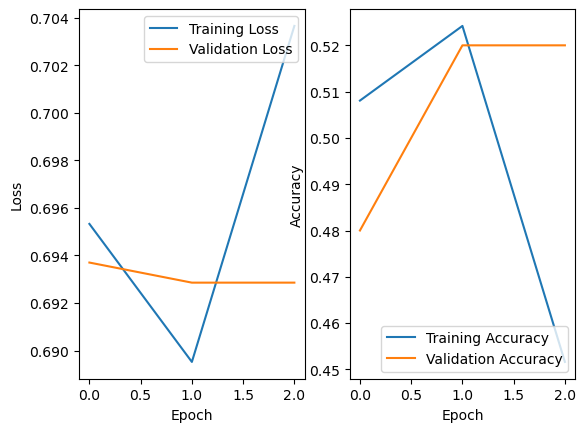

In [21]:
epochs = 3

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


2024-10-01 10:05:09.034262: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


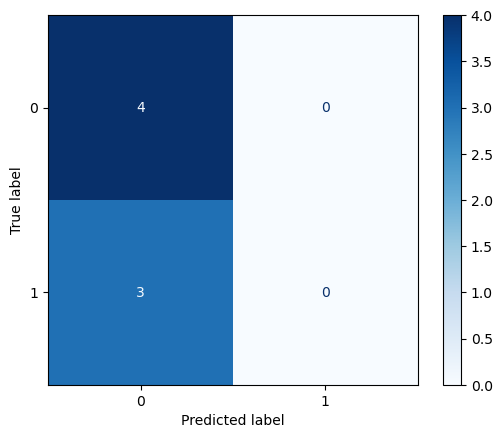

In [22]:
predictions = model.predict(test_ds)

binary_predictions = np.where(predictions > 0.5, 1, 0)

# Step 3: Extract the true labels from the validation or test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Step 4: Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)



In [23]:
model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5714 - loss: 0.6919


[0.6918848752975464, 0.5714285969734192]